# Deep Learning for Computer Vision

---

**Goethe University Frankfurt am Main**

Winter Semester 2022/23

<br>

## *Assignment 6 (U-Net)*

---

**Points:** 110<br>
**Due:** 14.12.2022, 10 am<br>
**Contact:** Timothy Schaumlöffel (Discord)<br>

---

**Your Name:** Tilo-Lars Flasche

<br>

<br>

## Table of Contents

---

- [1 Dataset](#1-Dataset)
    - [1.1 Augmentations](#1.1-Augmentations-(15-Points))
- [2 Model](#2-Model-(20-Points))
- [3 Loss](#3-Loss-(20-Points))
- [4 Metric](#4-Metric-(20-Points))
 - [4.1 Accuracy](#4.1-Accuracy-(5-Points))
- [5 Training](#5-Training-(20-Points))
- [6 Mask RCNN](#6-Mask-RCNN-(10-Points))

# Getting Started
## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You"ll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# should be installed in Colab
!pip install -U albumentations


[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [3]:
from google.colab import drive

drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
from pathlib import Path
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A5 folder, then "2022WI/A4"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = ''
ROOT_PATH = Path("drive", "My Drive") / GOOGLE_DRIVE_PATH_AFTER_MYDRIVE
print(list(ROOT_PATH.iterdir()))

# Add to sys so we can import .py files.
sys.path.append(str(ROOT_PATH))

In [4]:
import torch
from torchvision import datasets
import numpy as np
import multiprocessing
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from functools import partial
from helper import plot_segmentation, plot_history

In [ ]:
# Set a few constants related to data loading.
NUM_CLASSES = 3
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224)
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)
NUM_WORKERS = multiprocessing.cpu_count()

if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

<br>

# 1 Dataset

---

## Oxford-IIIT Pet
---
In the last exercise we used bounding boxes to predict the location and class of objects in images. In this exercise
we want to train a model on the task of semantic segmentation.

In semantic segmentation we want to predict a mask for each image. Each pixel in the mask should be labeled with the
class of the object it belongs to. Consequently the mask has the same size as the image and each pixel is labeled with
an integer between 0 and the number of classes - 1.

We will use [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), which contains images of cats and dogs.
The dataset is available in torchvision and we can load it with torchvision.datasets.OxfordPets. The dataset contains
annotations for classification and segmentation masks. We will use the segmentation masks for this exercise.

Run the following cell to download the dataset automatically and show one example.


In [ ]:
ROOT_PATH = '/media/ts/SSD_ubuntu/datasets/'
dataset = datasets.OxfordIIITPet(root=ROOT_PATH, target_types='segmentation', download=True)
print(dataset)

image, mask = dataset[0]
plot_segmentation(image, mask)

The dataset contains three classes (we will scale the index to start at 0 in the dataloader for you):
   * index 1 = foreground
   * index 2 = background
   * index 3 = border

Usually we want to ignore the border class and only predict foreground and background. To make this task a bit more interesting
we will also predict the border class. This means we will have **3 classes in total**.

## 1.1 Augmentations (15 Points)
Since the dataset is very small we will add some data augmentation to the training set. For this we introduce the library
**albumentations**, which contains a large collection of augmentation and is very popular in the computer vision community.
One of the advantages of albumentations is that it applies the same augmentation to the image and the mask if necessary.

**TODO**: Make yourself familiar with the [documentation](https://albumentations.ai/docs/) of albumentations ([List of Tranforms](https://albumentations.ai/docs/getting_started/transforms_and_targets/)). Implement
the augmentation pipeline for training and validation. Use the following augmentation for the training set:
   * Crop a random part of the image and resize it to `IMAGE_SHAPE`. Crop minimum 60% of the image and maximum 100%. Use aspect rations between 0.75 and 1.33.
   * Horizontal flip with probability 0.5
   * With probability 0.9 **either** CLAHE **or** random brightness & contrast
   * With probability 0.9 **either** random gamma **or** random hue, saturation and value


The validation set should only be resized to `IMAGE_SHAPE`.

Of cause normalize the image using `MEAN` and `STD` and convert it to a Pytorch tensor with `ToTensorV2()` at the end.
If not specified use default parameters for the augmentation.


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

############################################################
###                  START OF YOUR CODE                  ###
############################################################
train_transform = None
test_transform = None
############################################################
###                   END OF YOUR CODE                   ###
############################################################

Now the augmentation pipeline is implemented we can start with the dataloader. To apply the albumantations pipeline to the
torchvision dataset we need the helper `apply_transform`, that converts the PIL images to numpy arrays, applies the
transformations and extracts the result. Have a look at the helper function and run the following cells to see some examples of your augmented images and masks.

In [ ]:
def apply_transform(image, mask, train=True):
    # choose either train or test transform
    func = train_transform if train else test_transform
    # convert image and mask von PIL.Image to numpy.ndarray and apply albumentations style transform
    res = func(image=np.array(image), mask=np.array(mask))
    # extract image and mask from the result
    # subtract 1 from mask to make it 0-based
    return res['image'], res['mask'] - 1


train_ds = datasets.OxfordIIITPet(root=ROOT_PATH,
                                  target_types='segmentation',
                                  transforms=partial(apply_transform, train=True),
                                  split='trainval')

val_ds = datasets.OxfordIIITPet(root=ROOT_PATH,
                                target_types='segmentation',
                                transforms=partial(apply_transform, train=False),
                                split='test')

# create dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)

In [4]:
train_loader_iter = iter(train_loader)
images, masks = next(train_loader_iter)

print(f"Images have shape   : {images.shape}")
print(f"Masks have shape    : {masks.shape}")

# create inverse transform to visualize images
inverse = A.Compose([
    A.Normalize(mean=[-m / s for m, s in zip(MEAN, STD)], std=[1 / s for s in STD], max_pixel_value=1.0)
])

for i in range(3):
    img = images[i].permute(1, 2, 0)  # swap channels
    img = inverse(image=img.numpy())['image']
    plot_segmentation(img, masks[i])

NameError: name 'train_loader' is not defined

<br>

# 2 Model (20 Points)

---

## U-NET
---
[U-Net](https://arxiv.org/pdf/1505.04597.pdf) is a deep learning architecture that is commonly used for image segmentation tasks. It was first proposed in 2015 by researchers at the University of Freiburg in Germany, and it has since been widely used in various applications, such as medical imaging and satellite image analysis.

U-Net is a fully convolutional network, which means that it is composed entirely of convolutional layers, with no fully-connected layers. This allows it to take in inputs of arbitrary size and produce output segmentation masks of the same size. The architecture of U-Net is designed to be highly symmetrical, with a "down-sampling" path that encodes the input image into a compact representation, and a "up-sampling" path that decodes the compact representation back into a full-sized output mask.

One of the key features of U-Net is its use of skip connections, which allows it to combine low-level details from the down-sampling path with high-level context from the up-sampling path. This helps the network to make more accurate segmentation predictions by leveraging both local and global information about the input image.


<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="U-Net architecture figure" width="70%">

We will follow the idea of U-Net, but we will not implement exactly the same architecture as in the figure. Instead, we will use a pre-trained encoder and extend it with our own decoder. This will speed up the convergence of the network and reduce the amount of computational resources. We use the same `regnet_x_400mf` pretrained on ImageNet as in the previous task, but this time we take features from five positions. Execute the following cell to print the output shapes of the encoder.

In [ ]:
from unet import Encoder

encoder = Encoder()

Now you can implement the decoder. For this purpose, a DecoderBlock is defined that receives both the skip connection from the encoder and the bottom-up stream and merges them accordingly by upsampling.
**TODO**: Follow the instructions in `unet.py` and implement all methods in `DecoderBlock()` and `Decoder()`.

In [ ]:
from unet import UNet

model = UNet(num_classes=10)
x = torch.rand(2, 3, 224, 224)
y = model(x)

print(f"[Test Model]: {tuple(y.shape) == (2, 10, 224, 224)}")

<br>

# 3 Loss (20 Points)

---

## Dice Loss
---
We want to implement the multi-class **Dice Loss**, a popular loss function from the field of medical image segmentation. It measures the overlap between the predicted and the ground truth sample.

For classes $c \in C$ and samples $i \in I$: $y_i^{(c)}$ is the one-hot encoding (0 or 1) of class $c$ and $\hat{y}_i^{(c)}$ is the probability for the example and class. The Dice Loss defined as:

$$
    L(y, \hat{y}) = 1 - \frac{2}{|C|} \cdot \sum_{c \in C} \frac{\sum_{i} y_i^{(c)} \hat{y}_i^{(c)} + \epsilon}{\sum_{i} \left(y_i^{(c)} + \hat{y}_i^{(c)} \right) + \epsilon}
$$
where $\epsilon$ is a constant to avoid dividing by zero.

---

**TODO**: Implement the forward pass of the class `DiceLoss` in `loss.py` and test your implementation in the cell below. It expects the logits of the model, so you must apply softmax to get probabilities. For numerical stability, use log_softmax and then exponentiate. The target is expected to be in one-hot format.

In [ ]:
from loss import DiceLoss

# model output of shape (N, C, H, W)
logits = torch.tensor([[[[0.1261, 0.4626, 1.5762],
                         [1.5561, -0.0415, -0.0891],
                         [0.7072, 0.1905, -0.8896]],

                        [[-1.4516, -0.6939, -0.2739],
                         [1.5394, 1.1466, 0.7905],
                         [-3.0648, -1.0307, 0.7960]]]])
# one-hot ground truth of shape (N, C, H, W)
target = torch.tensor([[[[1, 1, 0],
                         [1, 0, 1],
                         [1, 1, 0]],

                        [[0, 0, 1],
                         [0, 1, 0],
                         [0, 0, 1]]]])

expected_loss = torch.tensor(0.37266626954078674)

dice = DiceLoss(reduce='mean')
loss = dice(logits, target)
passed = abs(loss - expected_loss) < 1e-5

print(f"[Test Loss]: {passed}")

<br>

# 4 Metric (20 Points)

---
The performance of the segmentation will be evaluated with the **Intersection over Union** (Jaccard Index) and **Accuracy**. These metrics can be formulated with the results of a confusion matrix:
$$
    \text{IoU} = \frac{\text{TP}}{\text{TP} + \text{FN} + \text{FP}}
$$
$$
    \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN}+ \text{FN} + \text{FP}}
$$
with TP=True positives, TN=True negatives, FP=False positives and FN=False negatives.

These values should be calculated pixel-wise for every class, to get the overall scores for the image.

---

**TODO**: Implement the functions `stat_scores()` to calculate the values of the confusion matrix as well as `accuracy_score()` and `iou_score()` in `metric.py` and test your implementation below.

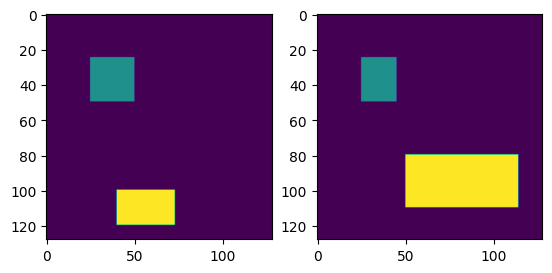

tensor(730) tensor(1690) tensor(555) tensor(13409)
[Test Stats]: False
[Test IoU]: False
[Test Accuracy]: False


In [9]:
from metrics import stat_scores, iou_score, accuracy_score

# create some dummy input with three classes
test_img1 = torch.zeros(128, 128)
test_img1[25:50, 25:50] = 1
test_img1[100:120, 40:73] = 2

test_img2 = torch.zeros(128, 128)
test_img2[25:50, 25:45] = 1
test_img2[80:110, 50:114] = 2

fig, ax = plt.subplots(1, 2)
ax[0].imshow(test_img1)
ax[1].imshow(test_img2)
plt.show()

expected_iou, expected_acc = 0.7589779496192932, 0.9086506962776184
expected_stats = torch.tensor([14139, 2245, 2245, 30523])

tp, fp, fn, tn = stat_scores(test_img1, test_img2, num_classes=3)
print(tp, fp, fn, tn)
print(f"[Test Stats]: {torch.allclose(torch.stack([tp, fp, fn, tn]), expected_stats)}")

iou = iou_score(tp, fp, fn, tn)
print(f"[Test IoU]: {abs(iou - expected_iou) < 1e-5}")

acc = accuracy_score(tp, fp, fn, tn)
print(f"[Test Accuracy]: {abs(acc - expected_acc) < 1e-5}")

## 4.1 Accuracy (5 Points)
**TODO**: The accuracy score is rarely used in semantic segmentation because it can lead to misleading results. Briefly explain in your own words what the problem with accuracy is.

##### Answer

*Write your answer here.*

<br>

# 5 Training (20 Points)

At this point, only three small things are missing to train the model. 1. The ground truth masks from the data loader have the shape `(N, H, W)`, so an integer represents the class label. But our loss function expects one-hot encoded targets. 2. For the evaluation with our created metrics we have to convert the output of the network into probabilities. 3. We need to calculate our metrics during training.

---

**TODO**: Implement two missing parts in `Solver.test()`, `Solver.infer()` and `Solver.train()` in `solver.py` and train the network for 10 epochs.

In [ ]:
from solver import Solver
from loss import DiceLoss
from unet import UNet

loss = DiceLoss(reduce='mean')
model = UNet(num_classes=NUM_CLASSES)

solver = Solver(train_loader, val_loader, model, loss, DEVICE)
hist = solver.train(num_epochs=10)

plot_history(hist, save=None)

The expected IoU-Score should be between 80-90%. Let's look at some predictions:

In [ ]:
images, masks = next(iter(val_loader))
pred_masks = solver.infer(images)

for image, mask, pred_mask in zip(images, masks, pred_masks):
    image = image.permute(1, 2, 0)
    image = inverse(image=image.numpy())['image']
    plot_segmentation(image, mask, pred_mask)

<br>

# 6 Mask RCNN (10 Points)

---

In the last exercise we implemented the two-stage object detector Faster R-CNN. In the lecture, [Mask R-CNN](https://arxiv.org/pdf/1703.06870.pdf) was presented, that extends this approach to accomplish the segmentation task.
 **TODO:** Briefly describe the stages of Mask R-CNN (RPN -> Fast R-CNN) and explain how the segmentation is performed. Also describe why *RoIAlign* is used in this context and what problem it solves compared to *RoiPool*.


##### Answer

*Write your answer here.*
